# Convergence plots: Helmholtz equation on a Stanford bunny geometry with trigonometric true solution

In [4]:
# Imports
import sys
sys.path.append('../../')
sys.path.append('../../src')
from swimpde import Domain
from swimpde import BasicAnsatz
from swimpde import HelmholtzSolver
import numpy as np
from sklearn.metrics import mean_squared_error, max_error
import csv
from sklearn.model_selection import train_test_split
import numpy as np
import time
import alphashape
import matplotlib.pyplot as plt

### Problem setup

In [5]:
# Create sample points on a sphere using Fibbonacci lattice rule
file = open('../../data/bunny_vertices.csv')
csvreader = csv.reader(file)
data_points = []
for row in csvreader:
    data_points.append(row)
file.close()
data_points = np.array(data_points)
data_points = np.array(data_points ,dtype=float)


# Create alpha shape
alpha = 1e-4

alpha_shape = alphashape.alphashape(data_points, alpha)

# Extract the vertices of the alpha shape
vertices = np.array(alpha_shape.vertices)

# Find the indices of the data points that are vertices of the alpha shape
indices = []
for vertex in vertices:
    index = np.where((data_points == vertex).all(axis=1))[0][0]
    indices.append(index)

boundary_data = data_points[indices]

# Keep npn-boundary data
indices_to_keep = sorted(set(range(len(data_points))) - set(indices))
interior_data = data_points[indices_to_keep]
boundary_train, boundary_test = train_test_split(boundary_data, test_size=0.1, random_state=42)

# No boundary condition! This is mentioned just to pass it as an argument!
boundary_condition = "zero dirichlet"

# forcing
def forcing(v):
    u = 5. + np.sin(np.pi * v[:, 0]) * np.sin(1 * np.pi * v[:, 1])  * np.sin(4 * np.pi * v[:, 2]) 
    u_xx = -18. * np.pi**2 * (u - 5.)
    return u_xx - u

def analytical_sol(v):
    return 5. + np.sin(np.pi * v[:, 0]) * np.sin(1 * np.pi * v[:, 1])  * np.sin(4 * np.pi * v[:, 2]) 


### Fit and evaluate on test data

In [6]:
experiments = []
seeds = [1, 2, 3]
n_s = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
ratios = [2]
reg = [1e-12]
for i1 in n_s: # Number of training data points
    for i2 in ratios:
        for i3 in reg:
            info = []
            # Number of basis functions
            n_b = int(i1//i2)
            # Train test split
            n_train = i1 #8171
            n_total = np.shape(interior_data)[0]
            n_test =  n_total - n_train

            X_train, X_test = train_test_split(interior_data, test_size=n_test/(n_train + n_test), random_state=42)
            X_test = np.vstack((X_test, boundary_test))
            print("Number of collocation points: ", n_train, "Number of boundary points (training): ",  np.shape(boundary_train)[0])
            print("Number of test points (uncluding boundary) : ", np.shape(X_test)[0])
            
            # True solution
            Y_train = analytical_sol(X_train)
            Y_test = analytical_sol(X_test)

            # boundary points
            boundary_points = boundary_train
            interior_points = X_train
            domain = Domain(
                interior_points=interior_points,
                boundary_points=boundary_points,
            )
            # Loop over different seeds
            rmse_swim = np.ones((len(seeds), ))
            rmse_elm = np.ones((len(seeds), ))
            rel_err_swim = np.ones((len(seeds), ))
            rel_err_elm = np.ones((len(seeds), ))
            time_swim = np.ones((len(seeds), ))
            time_elm = np.ones((len(seeds), ))
            rel_err_elm_train = np.ones((len(seeds), ))
            rel_err_swim_train = np.ones((len(seeds), ))

            for i4 in seeds:
                # Ansatz
                ansatz_elm = BasicAnsatz(
                    activation='tanh',
                    n_neurons=n_b,
                    random_state=i4,
                    regularization_scale=i3,
                    parameter_sampler="random"
                )

                ansatz_swim = BasicAnsatz(
                    activation='tanh',
                    n_neurons=n_b,
                    random_state=i4,
                    regularization_scale=i3,
                    parameter_sampler="tanh"
                )

                helmholtz_solver_swim = HelmholtzSolver(
                    domain=domain, 
                    ansatz=ansatz_swim,
                    forcing=forcing,
                    regularization_scale=i3
                )

                helmholtz_solver_elm = HelmholtzSolver(
                    domain=domain, 
                    ansatz=ansatz_elm,
                    forcing=forcing,
                    regularization_scale=i3
                )

                t_swim_start = time.time()
                helmholtz_solver_swim.fit(num_svd=min(2000, int(i1//5 ) - 1), analytical_sol=analytical_sol);
                t_swim_stop = time.time()
                time_swim[i4-1] = t_swim_stop - t_swim_start
                
                # Evaluate U-SWIM
                sol_train_swim = helmholtz_solver_swim.evaluate(X_train)
                sol_test_swim =  helmholtz_solver_swim.evaluate(X_test)

                t_elm_start = time.time()
                helmholtz_solver_elm.fit(num_svd=min(2000, int(i1//5 ) - 1), analytical_sol=analytical_sol);
                t_elm_stop = time.time()
                time_elm[i4-1] = t_elm_stop - t_elm_start
                
                # Evaluate ELM
                sol_train_elm = helmholtz_solver_elm.evaluate(X_train)
                sol_test_elm =  helmholtz_solver_elm.evaluate(X_test)

                # Compte metrics
                mse_elm = mean_squared_error(sol_test_elm, Y_test)  # mean squared error
                rmse_elm[i4-1] = np.sqrt(mse_elm)  # Root Mean Squared Error
                mse_swim = mean_squared_error(sol_test_swim, Y_test)  # mean squared error
                rmse_swim[i4-1] = np.sqrt(mse_swim)  # Root Mean Squared Error
                
                rel_err_elm[i4-1] = np.linalg.norm(sol_test_elm - Y_test, 2)/np.linalg.norm(Y_test, 2)
                rel_err_swim[i4-1] = np.linalg.norm(sol_test_swim - Y_test, 2)/np.linalg.norm(Y_test, 2)
                
                
                rel_err_elm_train[i4-1] = np.linalg.norm(sol_train_elm - Y_train, 2)/np.linalg.norm(Y_train, 2)
                rel_err_swim_train[i4-1] = np.linalg.norm(sol_train_swim - Y_train, 2)/np.linalg.norm(Y_train, 2)

            info.append(i1)
            info.append(n_b)
            info.append(i3)
            info.append(np.mean(time_elm))
            info.append(np.mean(time_swim))

            info.append(np.mean(rmse_elm))
            info.append(np.mean(rmse_swim))

            info.append(np.mean(rel_err_elm))
            info.append(np.mean(rel_err_swim))

            print("n_s=", info[0], ", n_b =", n_b)
            print('(Mean) Time ELM: %e' % np.mean(time_elm))
            print('(Mean) Time SWIM: %e' % np.mean(time_swim))
            
            print('(Mean) ELM Relative L2 error (Test): %e' % np.mean(rel_err_elm))
            print('(Mean) ELM Relative L2 error on (Train): %e' % np.mean(rel_err_elm_train))
            print('(Mean) ELM RMSE (Test): %e' % np.mean(rmse_elm))

            print('(Mean) SWIM Relative L2 error (Test): %e' % np.mean(rel_err_swim))
            print('(Mean) SWIM Relative L2 error on the (Train): %e' % np.mean(rel_err_swim_train))
            print('(Mean) SWIM RMSE (Test): %e' % np.mean(rmse_swim))
            experiments.append(info)





Number of collocation points:  1000 Number of boundary points (training):  888
Number of test points (uncluding boundary) :  13370
n_s= 1000 , n_b = 500
(Mean) Time ELM: 1.000155e+00
(Mean) Time SWIM: 7.282288e-01
(Mean) ELM Relative L2 error (Test): 5.135359e-01
(Mean) ELM Relative L2 error on (Train): 4.996485e-01
(Mean) ELM RMSE (Test): 2.592240e+00
(Mean) SWIM Relative L2 error (Test): 2.021702e-01
(Mean) SWIM Relative L2 error on the (Train): 2.012427e-01
(Mean) SWIM RMSE (Test): 1.020520e+00
Number of collocation points:  2000 Number of boundary points (training):  888
Number of test points (uncluding boundary) :  12370
n_s= 2000 , n_b = 1000
(Mean) Time ELM: 4.650438e+00
(Mean) Time SWIM: 5.124929e+00
(Mean) ELM Relative L2 error (Test): 8.692630e-02
(Mean) ELM Relative L2 error on (Train): 8.681524e-02
(Mean) ELM RMSE (Test): 4.387629e-01
(Mean) SWIM Relative L2 error (Test): 6.340827e-02
(Mean) SWIM Relative L2 error on the (Train): 6.241626e-02
(Mean) SWIM RMSE (Test): 3.2005

### Convergence plots

(10, 9)


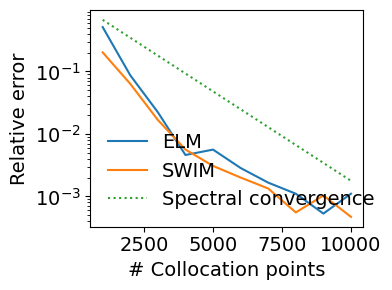

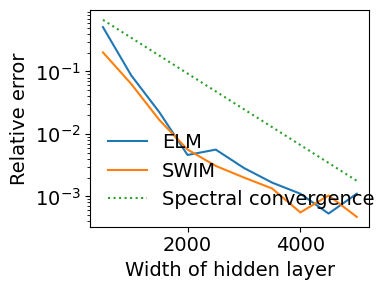

In [26]:
# Convergence plots
res = np.vstack(experiments)
with open('convergence_trig.npy', 'wb') as f:
    np.save(f, np.array([1, 2]))

print(np.shape(res))

# Plots
j = 6
jump = len(ratios) * len(reg)
for i in range(len(n_s)): #reg_pinv_ic scale_bc ratios
    rel_err_elm = min(res[(i*jump):((i+1)*jump), j+1])
    rel_err_swim = min(res[(i*jump):((i+1)*jump), j+2])
    # rel_err_swim_rs = min(res[(i*jump):((i+1)*jump), j+3])

# Spectral convergence line
x1 = n_s[0]
x2 = n_s[-2]
y1 = res[0, 8]
y2 = res[-2, 8]

# Compute the slope and intercept of the line (y = mx + c)
m = (np.log(y2) - np.log(y1)) / (x2 - x1)  # Using log to convert to semilogy plot
c = np.log(y1) - m * x1 + 1.2

# Define x-values for the line
x_values = np.array(n_s) #np.linspace(x1, x2, 100)

# Calculate corresponding y-values using the equation of the line
y_values = np.exp(m * x_values + c)  # Exponentiating to revert back from log scale

fontsize = 14
fig, ax = plt.subplots(1, 1, figsize=(4, 3), sharey=True)
n_s = np.asarray(n_s)
ax.semilogy(n_s, res[:, 7])
ax.semilogy(n_s, res[:, 8])
ax.semilogy(x_values, y_values, ':', label='Spectral convergence')# * 50
ax.legend(["ELM", "SWIM", "Spectral convergence"], frameon=False, loc='lower left', fontsize=fontsize)
ax.set_xlabel('# Collocation points', fontsize=fontsize)
ax.set_ylabel('Relative error', fontsize=fontsize)
plt.tick_params(axis='both', labelsize=fontsize)
fig.tight_layout()
plt.savefig('convergence_trig_1.pdf')

# Spectral convergence line
x1 = n_s[0]/2
x2 = n_s[-2]/2
y1 = res[0, 8]
y2 = res[-2, 8]

# Compute the slope and intercept of the line (y = mx + c)
m = (np.log(y2) - np.log(y1)) / (x2 - x1)  # Using log to convert to semilogy plot
c = np.log(y1) - m * x1 + 1.2

# Define x-values for the line
#x_values /= 2 #int(x_values/2) #np.linspace(x1, x2, 100)

# Calculate corresponding y-values using the equation of the line
y_values = np.exp(m * x_values/2 + c)  # Exponentiating to revert back from log scale
fig, ax = plt.subplots(1, 1, figsize=(4, 3), sharey=True)
n_s = np.asarray(n_s)
ax.semilogy(n_s/2, res[:, 7])
ax.semilogy(n_s/2, res[:, 8])
ax.semilogy(x_values/2, y_values, ':', label='Spectral convergence')
ax.legend(["ELM", "SWIM", "Spectral convergence"], frameon=False, loc='lower left', fontsize=fontsize)
ax.set_xlabel('Width of hidden layer', fontsize=fontsize)
ax.set_ylabel('Relative error', fontsize=fontsize)
plt.tick_params(axis='both', labelsize=fontsize)
fig.tight_layout()
plt.savefig('convergence_trig_2.pdf')